# Exploring AcousticBrainz classifier stability 

AcousticBrainz has a large amount of classifier information available, and is used quite often as a source for psychological claims based on music like listening preferences over time, the influence of the seasons on our preferences, or claims that [pop music is getting sadder](http://www.bbc.com/culture/story/20190513-is-pop-music-really-getting-sadder-and-angrier).

Low level features are known to be unstable (see reference in my notes), so the hypothesis is that these results from the AcousticBrainz classifiers are very much dependent on things like source quality. Furthermore, high-level features have additional problems like which emotion model do you use, and differences in interpretation, for example: how do you interpret a 'party mood'? Furthermore, the 'ground truth' that these models are trained on is also subjective. If scientific claims made using the results from such classifiers as a basis, then these claims might not be true if the classifiers are unreliable.

Due to the crowdsourcing nature of AcousticBrainz, multiple submissions exist for the same recording, meaning that the classifier has been run multiple times over different submissions of the same recording. If these classifiers are accurate, then the results should remain fairly stable when minor variations in for example audio quality occur - a sad song should not become happy if the quality is higher, for example. 

Thus, the first question to answer is: **How stable are the classifiers included in AcousticBrainz** and a second question that arises is **Which classifiers are relatively stable, and which classifiers are relatively unstable?**


First, we import all required packages and load in the acousticbrainz dataset which was generated by running the scripts in ```acousticbrainz_data_generation```:

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainz.h5')

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def get_ci95(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    #se = a.var() / math.sqrt((samplesizes).sum())
    se = a.sem()
    ci_95 = se * scipy.stats.t.ppf(0.975, samplesizes.sum())
    
    return ci_95

C:\Users\Chris\Miniconda3\envs\thesis2\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


The dataframe is indexed into two levels. The first level is the MBID and the second level is the submission id. Cell values are the label probabilities as given back by the classifier. The dataframe looks as follows:

In [2]:
acousticbrainz

danceability                  gender  \
                                           danceable not_danceable    female   
000009a8-34f1-4c58-a8de-1d99809cd626 0  3.000001e-14      1.000000  0.622127   
                                     1  2.751654e-01      0.724835  0.588847   
00000baf-9215-483a-8900-93756eaf1cfc 0  9.999093e-01      0.000091  0.500000   
                                     1  9.999142e-01      0.000086  0.500000   
                                     2  3.000001e-14      1.000000  0.622127   
...                                              ...           ...       ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0  3.000001e-14      1.000000  0.622127   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0  2.363820e-01      0.763618  0.172870   
ffff9c3f-85da-404e-b2e8-14a500b62648 0  2.547902e-01      0.745210  0.777648   
ffffa8a0-5949-403d-aa19-ec7346db2254 0  3.602032e-01      0.639797  0.003200   
ffffaa0d-b638-4644-8c70-c61988748146 0  7.001088e-01      0.299891  0.399590   

                                                 genre_dortmund            \
                                            male    alternative     blues   
000009a8-34f1-4c58-a8de-1d99809cd626 0  0.377873       0.048124  0.010853   
                                     1  0.411153       0.276660  0.022330   
00000baf-9215-483a-8900-93756eaf1cfc 0  0.500000       0.123210  0.029354   
                                     1  0.500000       0.122299  0.029067   
                                     2  0.377873       0.001199  0.000155   
...                                          ...            ...       ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0  0.377873       0.001664  0.000172   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0  0.827130       0.183566  0.053612   
ffff9c3f-85da-404e-b2e8-14a500b62648 0  0.222352       0.147801  0.104918   
ffffa8a0-5949-403d-aa19-ec7346db2254 0  0.996800       0.087463  0.015773   
ffffaa0d-b638-4644-8c70-c61988748146 0  0.600410       0.203939  0.052335   

                                                                           \
                                       electronic folkcountry funksoulrnb   
000009a8-34f1-4c58-a8de-1d99809cd626 0   0.815454    0.032144    0.002521   
                                     1   0.096782    0.438989    0.004316   
00000baf-9215-483a-8900-93756eaf1cfc 0   0.678225    0.018370    0.004644   
                                     1   0.678300    0.017725    0.004513   
                                     2   0.997356    0.000136    0.000028   
...                                           ...         ...         ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0   0.997439    0.000236    0.000015   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0   0.496118    0.140909    0.008814   
ffff9c3f-85da-404e-b2e8-14a500b62648 0   0.152298    0.328587    0.013151   
ffffa8a0-5949-403d-aa19-ec7346db2254 0   0.857965    0.019118    0.001772   
ffffaa0d-b638-4644-8c70-c61988748146 0   0.483098    0.132330    0.010449   

                                                  ... moods_mirex            \
                                            jazz  ...    Cluster2  Cluster3   
000009a8-34f1-4c58-a8de-1d99809cd626 0  0.059219  ...    0.044404  0.227748   
                                     1  0.097606  ...    0.359569  0.389190   
00000baf-9215-483a-8900-93756eaf1cfc 0  0.027921  ...    0.059108  0.078950   
                                     1  0.029749  ...    0.059855  0.078234   
                                     2  0.000596  ...    0.044404  0.227748   
...                                          ...  ...         ...       ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0  0.000166  ...    0.044404  0.227748   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0  0.013020  ...    0.256713  0.245888   
ffff9c3f-85da-404e-b2e8-14a500b62648 0  0.018729  ...    0.502939  0.170402   
ffffa8a0-5949-403d-aa19-ec7346db2254 0  0.002774  ...    0.097182  0.424299   
ffffaa0d-b638-4644-8c70-c61988748146 0  0.02363

Some recordings have many submissions, like `Bohemian Rhapsody`:

In [3]:
acousticbrainz.loc['b1a9c0e9-d987-4042-ae91-78d6a3267d69']

danceability                  gender           genre_dortmund  \
       danceable not_danceable    female      male    alternative   
0   1.489382e-01      0.851062  0.578761  0.421239   1.375808e-08   
1   2.619256e-01      0.738074  0.596835  0.403165   1.789594e-08   
2   1.438872e-01      0.856113  0.566937  0.433063   1.386684e-08   
3   3.000001e-14      1.000000  0.622127  0.377873   1.741867e-10   
4   1.855529e-01      0.814447  0.628536  0.371464   2.096072e-08   
5   1.131953e-01      0.886805  0.928412  0.071588   3.121276e-08   
6   1.512170e-01      0.848783  0.798306  0.201694   1.611008e-08   
7   3.000001e-14      1.000000  0.622127  0.377873   1.525879e-10   
8   1.466795e-01      0.853320  0.640508  0.359492   1.397012e-08   
9   3.000001e-14      1.000000  0.622127  0.377873   1.595018e-10   
10  1.043248e-01      0.895675  0.928416  0.071583   3.553267e-08   
11  1.465200e-01      0.853480  0.579348  0.420652   1.567082e-08   
12  3.000001e-14      1.000000  0.622127  0.377873   1.903747e-10   
13  1.513230e-01      0.848677  0.794744  0.205256   1.865387e-08   
14  1.112669e-01      0.888733  0.927525  0.072475   2.017419e-08   
15  1.513200e-01      0.848680  0.794757  0.205243   1.862614e-08   
16  1.627407e-01      0.837259  0.776377  0.223623   3.098988e-08   
17  8.379228e-02      0.916208  0.904909  0.095091   3.375357e-08   
18  1.056962e-01      0.894304  0.944760  0.055240   3.879062e-08   
19  1.043752e-01      0.895625  0.944625  0.055375   3.315662e-08   
20  1.513212e-01      0.848679  0.794675  0.205325   1.864649e-08   
21  2.644571e-01      0.735543  0.585995  0.414005   1.746595e-08   
22  2.243684e-01      0.775632  0.731415  0.268585   1.935842e-08   
23  3.000001e-14      1.000000  0.622127  0.377873   2.182271e-10   
24  1.529199e-01      0.847080  0.637218  0.362782   1.936153e-08   
25  1.438274e-01      0.856173  0.566681  0.433319   1.386250e-08   
26  2.174793e-01      0.782521  0.706007  0.293993   2.248095e-08   
27  1.422642e-01      0.857736  0.790721  0.209279   1.791100e-08   
28  1.663786e-01      0.833621  0.780534  0.219466   3.028658e-08   

                                                                   ...  \
           blues electronic   folkcountry   funksoulrnb      jazz  ...   
0   1.664143e-08   0.999978  7.003212e-06  2.726350e-07  0.000014  ...   
1   2.162740e-08   0.999980  7.017995e-06  2.669164e-07  0.000012  ...   
2   1.677844e-08   0.999978  7.049242e-06  2.723325e-07  0.000014  ...   
3   1.964787e-10   0.999995  3.106572e-07  4.512222e-08  0.000004  ...   
4   2.513858e-08   0.999976  8.445537e-06  3.218076e-07  0.000014  ...   
5   3.676380e-08   0.999970  9.376518e-06  3.101730e-07  0.000019  ...   
6   1.925473e-08   0.999977  7.245709e-06  2.484353e-07  0.000014  ...   
7   1.720485e-10   0.999996  2.916429e-07  3.915462e-08  0.000004  ...   
8   1.685370e-08   0.999978  7.063604e-06  2.700113e-07  0.000014  ...   
9   1.858952e-10   0.999996  3.262027e-07  4.674204e-08  0.000004  ...   
10  4.200901e-08   0.999969  1.009045e-05  3.303849e-07  0.000019  ...   
11  1.892473e-08   0.999976  7.825191e-06  2.887224e-07  0.000015  ...   
12  2.237735e-10   0.999995  3.749371e-07  5.526630e-08  0.000004  ...   
13  2.226930e-08   0.999976  7.860697e-06  2.663921e-07  0.000015  ...   
14  2.378714e-08   0.999976  7.137827e-06  3.167831e-07  0.000015  ...   
15  2.222968e-08   0.999976  7.868952e-06  2.665049e-07  0.000015  ...   
16  3.790816e-08   0.999967  1.316549e-05  3.890198e-07  0.000018  ...   
17  4.032304e-08   0.999970  9.902794e-06  3.487879e-07  0.000019  ...   
18  4.556017e-08   0.999967  1.060824e-05  3.431911e-07  0.000021  ...   
19  3.898134e-08   0.999969  9.358158e-06  3.948015e-07  0.000020  ...   
20  2.226055e-08   0.999976  7.859158e-06  2.663654e-07  0.000015  ...   
21  2.122067e-08   0.999980  6.862603e-06  2.668032e-07  0.000012  ...   
22  2.303551e-08   0.999979  7.331588e-06  2.790628e-07  0.000013  ...   
23  2.527938e-

The dataframe contains the following classifications:

In [4]:
acousticbrainz.columns

MultiIndex([(      'danceability',           'danceable'),
            (      'danceability',       'not_danceable'),
            (            'gender',              'female'),
            (            'gender',                'male'),
            (    'genre_dortmund',         'alternative'),
            (    'genre_dortmund',               'blues'),
            (    'genre_dortmund',          'electronic'),
            (    'genre_dortmund',         'folkcountry'),
            (    'genre_dortmund',         'funksoulrnb'),
            (    'genre_dortmund',                'jazz'),
            (    'genre_dortmund',                 'pop'),
            (    'genre_dortmund',           'raphiphop'),
            (    'genre_dortmund',                'rock'),
            (  'genre_electronic',             'ambient'),
            (  'genre_electronic',                 'dnb'),
            (  'genre_electronic',               'house'),
            (  'genre_electronic',              'techno'

# Classifier variance
There are multiple ways to look at this, we can either see how stable the *probabilities* are, i.e. how stable is the certainty of the classifier in the label being a specific value or we can see how stable the *labels* are, i.e. for all submissions are the labels the same or do they flip?

We'll begin with the first case.

We are interested in the probability values for a given label for the independent variable mbid. Some mbids only have one submission. These do not give us any information about the variance and should be filtered out:

In [5]:
filt = acousticbrainz.groupby(level=0).size() > 1
acousticbrainz_filt = acousticbrainz[filt[acousticbrainz.index.get_level_values(level=0)].values]

acousticbrainz_filt

danceability                  gender  \
                                           danceable not_danceable    female   
000009a8-34f1-4c58-a8de-1d99809cd626 0  3.000001e-14  1.000000e+00  0.622127   
                                     1  2.751654e-01  7.248346e-01  0.588847   
00000baf-9215-483a-8900-93756eaf1cfc 0  9.999093e-01  9.071009e-05  0.500000   
                                     1  9.999142e-01  8.580889e-05  0.500000   
                                     2  3.000001e-14  1.000000e+00  0.622127   
...                                              ...           ...       ...   
fffe453c-b68b-4e43-9cef-b6767a587415 2  4.945789e-01  5.054211e-01  0.474031   
                                     3  4.946274e-01  5.053725e-01  0.473776   
                                     4  9.999999e-01  1.000000e-07  0.622150   
                                     5  8.023580e-01  1.976421e-01  0.416326   
                                     6  4.088018e-01  5.911982e-01  0.447032   

                                                 genre_dortmund            \
                                            male    alternative     blues   
000009a8-34f1-4c58-a8de-1d99809cd626 0  0.377873       0.048124  0.010853   
                                     1  0.411153       0.276660  0.022330   
00000baf-9215-483a-8900-93756eaf1cfc 0  0.500000       0.123210  0.029354   
                                     1  0.500000       0.122299  0.029067   
                                     2  0.377873       0.001199  0.000155   
...                                          ...            ...       ...   
fffe453c-b68b-4e43-9cef-b6767a587415 2  0.525969       0.005022  0.002608   
                                     3  0.526224       0.005021  0.002607   
                                     4  0.377850       0.000541  0.000164   
                                     5  0.583674       0.006733  0.004116   
                                     6  0.552968       0.005876  0.003217   

                                                                           \
                                       electronic folkcountry funksoulrnb   
000009a8-34f1-4c58-a8de-1d99809cd626 0   0.815454    0.032144    0.002521   
                                     1   0.096782    0.438989    0.004316   
00000baf-9215-483a-8900-93756eaf1cfc 0   0.678225    0.018370    0.004644   
                                     1   0.678300    0.017725    0.004513   
                                     2   0.997356    0.000136    0.000028   
...                                           ...         ...         ...   
fffe453c-b68b-4e43-9cef-b6767a587415 2   0.970523    0.004708    0.000768   
                                     3   0.970527    0.004708    0.000768   
                                     4   0.997072    0.000250    0.000028   
                                     5   0.956743    0.006299    0.000994   
                                     6   0.964668    0.005396    0.000813   

                                                  ... moods_mirex            \
                                            jazz  ...    Cluster2  Cluster3   
000009a8-34f1-4c58-a8de-1d99809cd626 0  0.059219  ...    0.044404  0.227748   
                                     1  0.097606  ...    0.359569  0.389190   
00000baf-9215-483a-8900-93756eaf1cfc 0  0.027921  ...    0.059108  0.078950   
                                     1  0.029749  ...    0.059855  0.078234   
                                     2  0.000596  ...    0.044404  0.227748   
...                                          ...  ...         ...       ...   
fffe453c-b68b-4e43-9cef-b6767a587415 2  0.012312  ...    0.346396  0.130623   
                                     3  0.012311  ...    0.346324  0.130625   
                                     4  0.001558  ...    0.044661  0.220980   
                                     5  0.019151  ...    0.343183  0.130389   
                                     6  0.01522

We have many populations with relatively small sizes, and a few populations with a bit more (~30), however these are not sample sizes large enough to give us a good estimate of the classifier variance on the same songs.

However, we can calculate the variance for each individual population (with the probabilities in each population indexed $j=0,...,j=n_{i}-1$
$$s_{i}^{2} = \frac{1}{n_{i}-1} \sum_{j=0}^{j=n_{i}-1}(y_{j} - \bar{y_i})^2$$

And then compute the pooled variance for each classifier by taking the weighted average for all $k$ populations indexed $k=0,...,k-1$ 
$$s_{p}^{2} = \frac{\sum_{i=0}^{k-1}(n_{i}-1)s_{i}^{2}}{\sum_{i=0}^{k-1}(n_{i}-1)}$$

In [6]:
pooledvariance = get_variance(acousticbrainz_filt).mean()
print(pooledvariance.sort_values().to_string())

genre_dortmund      funksoulrnb            0.000011
                    pop                    0.000042
genre_tzanetakis    met                    0.000154
                    reg                    0.000236
                    dis                    0.000272
ismir04_rhythm      Rumba-Misc             0.000277
genre_dortmund      raphiphop              0.000295
genre_tzanetakis    cou                    0.000353
genre_rosamerica    spe                    0.000399
genre_tzanetakis    pop                    0.000411
                    blu                    0.000480
genre_electronic    dnb                    0.000497
genre_dortmund      jazz                   0.000760
ismir04_rhythm      Quickstep              0.000797
moods_mirex         Cluster1               0.000965
ismir04_rhythm      Rumba-International    0.000989
genre_tzanetakis    cla                    0.001387
genre_dortmund      blues                  0.001565
                    alternative            0.001726
            

In [7]:
print(pooledvariance.sort_values(ascending=False).to_latex(longtable=True))

\begin{longtable}{llr}
\toprule
               &             &         0 \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
voice\_instrumental & instrumental &  0.073534 \\
               & voice &  0.073534 \\
danceability & not\_danceable &  0.066811 \\
               & danceable &  0.066811 \\
timbre & bright &  0.058701 \\
               & dark &  0.058701 \\
tonal\_atonal & atonal &  0.056830 \\
               & tonal &  0.056830 \\
mood\_electronic & not\_electronic &  0.049802 \\
               & electronic &  0.049802 \\
mood\_party & party &  0.046484 \\
               & not\_party &  0.046484 \\
mood\_aggressive & not\_aggressive &  0.045529 \\
               & aggressive &  0.045529 \\
mood\_relaxed & not\_relaxed &  0.037327 \\
               & relaxed &  0.037327 \\
mood\_acoustic & not\_acoustic &  0.028181 \\
               & acoustic &  0.028181 \\
ismir04\_rhythm & Rumba-American &  0.026770 \\
moo

In [8]:
pd.__version__

'1.0.3'

# Confidence interval for the estimate
We calculate the [95% confidence interval](http://onlinestatbook.com/2/estimation/mean.html)

In [9]:
import scipy.stats

ci_95 = get_ci95(acousticbrainz_filt)

print(ci_95.sort_values().to_string())

genre_dortmund      funksoulrnb            3.613095e-07
                    pop                    5.592759e-07
genre_tzanetakis    reg                    4.457647e-06
                    cou                    4.955996e-06
                    dis                    5.035058e-06
                    met                    7.204082e-06
moods_mirex         Cluster1               7.281328e-06
genre_rosamerica    spe                    7.951778e-06
ismir04_rhythm      Rumba-Misc             8.268435e-06
                    Samba                  8.378892e-06
genre_electronic    dnb                    8.578323e-06
genre_tzanetakis    blu                    1.131812e-05
ismir04_rhythm      Quickstep              1.182080e-05
genre_dortmund      raphiphop              1.196482e-05
moods_mirex         Cluster4               1.217487e-05
genre_dortmund      alternative            1.266411e-05
genre_tzanetakis    pop                    1.282443e-05
ismir04_rhythm      Rumba-International    1.466

In [10]:
tab = pd.DataFrame([pooledvariance, ci_95]).transpose()
tab.columns = ['Pooled variance', '95% CI term']
print(tab.sort_values(by='Pooled variance', ascending=False).to_latex(longtable=True))

\begin{longtable}{llrr}
\toprule
               &             &  Pooled variance &   95\% CI term \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
voice\_instrumental & instrumental &         0.073534 &  2.338615e-04 \\
               & voice &         0.073534 &  2.338615e-04 \\
danceability & not\_danceable &         0.066811 &  2.310532e-04 \\
               & danceable &         0.066811 &  2.310532e-04 \\
timbre & bright &         0.058701 &  2.068124e-04 \\
               & dark &         0.058701 &  2.068124e-04 \\
tonal\_atonal & atonal &         0.056830 &  2.004491e-04 \\
               & tonal &         0.056830 &  2.004491e-04 \\
mood\_electronic & not\_electronic &         0.049802 &  1.670732e-04 \\
               & electronic &         0.049802 &  1.670732e-04 \\
mood\_party & party &         0.046484 &  1.646424e-04 \\
               & not\_party &         0.046484 &  1.646424e-04 \\
mood\_aggressi

# Discrete label variance
Some classifiers, like `voice_instrumental`, `danceability` and `timbre` have relatively high variance. In the context of these calculations, that means that these classifiers can be seen as being somewhat **unreliable** or **uncertain**, since the probability values for the labels for the same recordings vary a lot. Other classifiers, like `genre_dortmund` seem to be very **reliable**, with very low variance. However, are these classifiers more reliable or simply more biased, predicting the same label every time thus lowering the variance?

## 'Biasedness' of the classifiers
To quantify this, we first need to transform the probabilities to hard labels. For this we select the most probable label:

In [11]:
grouped = acousticbrainz.groupby(axis=1, level=0).idxmax(axis=1).applymap(lambda x: x[1])
grouped

danceability  gender genre_dortmund  \
000009a8-34f1-4c58-a8de-1d99809cd626 0  not_danceable  female     electronic   
                                     1  not_danceable  female    folkcountry   
00000baf-9215-483a-8900-93756eaf1cfc 0      danceable  female     electronic   
                                     1      danceable  female     electronic   
                                     2  not_danceable  female     electronic   
...                                               ...     ...            ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0  not_danceable  female     electronic   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0  not_danceable    male     electronic   
ffff9c3f-85da-404e-b2e8-14a500b62648 0  not_danceable  female    folkcountry   
ffffa8a0-5949-403d-aa19-ec7346db2254 0  not_danceable    male     electronic   
ffffaa0d-b638-4644-8c70-c61988748146 0      danceable    male     electronic   

                                       genre_electronic genre_rosamerica  \
000009a8-34f1-4c58-a8de-1d99809cd626 0          ambient              rhy   
                                     1          ambient              jaz   
00000baf-9215-483a-8900-93756eaf1cfc 0           trance              dan   
                                     1           trance              dan   
                                     2           trance              roc   
...                                                 ...              ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0          ambient              roc   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0           trance              roc   
ffff9c3f-85da-404e-b2e8-14a500b62648 0          ambient              pop   
ffffa8a0-5949-403d-aa19-ec7346db2254 0          ambient              pop   
ffffaa0d-b638-4644-8c70-c61988748146 0          ambient              pop   

                                       genre_tzanetakis       ismir04_rhythm  \
000009a8-34f1-4c58-a8de-1d99809cd626 0              jaz  Rumba-International   
                                     1              jaz                Tango   
00000baf-9215-483a-8900-93756eaf1cfc 0              jaz            ChaChaCha   
                                     1              jaz            ChaChaCha   
                                     2              jaz       Rumba-American   
...                                                 ...                  ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0              jaz       Rumba-American   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0              jaz            ChaChaCha   
ffff9c3f-85da-404e-b2e8-14a500b62648 0              jaz                Tango   
ffffa8a0-5949-403d-aa19-ec7346db2254 0              jaz                Tango   
ffffaa0d-b638-4644-8c70-c61988748146 0              jaz            ChaChaCha   

                                       mood_acoustic mood_aggressive  \
000009a8-34f1-4c58-a8de-1d99809cd626 0  not_acoustic  not_aggressive   
                                     1      acoustic  not_aggressive   
00000baf-9215-483a-8900-93756eaf1cfc 0  not_acoustic  not_aggressive   
                                     1  not_acoustic  not_aggressive   
                                     2  not_acoustic  not_aggressive   
...                                              ...             ...   
ffff5419-7355-4c06-9ad1-8e39f4d25627 0  not_acoustic  not_aggressive   
ffff6ec8-62eb-4791-b7aa-6a4394c12ae7 0  not_acoustic  not_aggressive   
ffff9c3f-85da-404e-b2e8-14a500b62648 0      acoustic  not_aggressive   
ffffa8a0-5949-403d-aa19-ec7346db2254 0      acoustic  not_aggressive   
ffffaa0d-b638-4644-8c70-c61988748146 0  not_acoustic  not_aggressive   

                                       mood_electronic mood_happy mood_party  \
000009a8-34f1-4c58-a8de-1d99809cd626 0      electronic  not_happy  not_party   
                                     1  not_electronic  not_happy  not_party   
00000baf-9215-483a-8900-93756eaf1cfc 0      electronic  not_happy  not_party   
                     

Now, for every column we can calculate the **entropy**, if a classifier always or nearly always produces the same result, then the informational value and thus the entropy will be low or even zero.
$$S_n(p)=-\sum_{i}p_{i}\log_2 p_{i}$$

With $$S_{max} = \log_2 n$$

To compare the entropies of the different classifiers, normalize them by their maximum values so every entropy falls in $[0,1]$:

$$S=-\sum_{i}\frac{p_i \log_2 p_i}{log_2 n}$$

Which is equivalent to

$$S=-\sum_{i}p_i \log_n p_i$$

In [12]:
from scipy.stats import entropy

probabilities = pd.DataFrame()
for c in grouped.columns:
    probabilities = probabilities.append(grouped[c].value_counts(normalize=True)).fillna(value=0)
    
normalizers = acousticbrainz.groupby(level = 0, axis = 1).size()

norm_entropy = probabilities.apply(lambda row: entropy(row, base=normalizers[row.name]), axis=1)
norm_entropy.sort_values()

genre_tzanetakis      0.210992
genre_dortmund        0.337265
genre_electronic      0.550274
mood_aggressive       0.684244
moods_mirex           0.686701
ismir04_rhythm        0.707772
mood_party            0.825267
mood_relaxed          0.877459
mood_sad              0.880068
mood_happy            0.892659
mood_acoustic         0.905857
genre_rosamerica      0.914024
danceability          0.922382
gender                0.956663
tonal_atonal          0.975303
mood_electronic       0.987134
timbre                0.992234
voice_instrumental    0.993270
dtype: float64

## Relation between biasedness and variance
Now we are interested in the relation between the entropy (i.e. roughly how biased the classifier is) and the variance of the probabilities of that classifier.

Note that for classifiers with only two labels, the variances of those two labels are the same (values are either one or the other), however for multiple labels the variances differ. For comparisons sake we take the average variance for each classifier.

In [13]:
avg_variance = pooledvariance.mean(level=0)
avg_variance.sort_values()

genre_tzanetakis      0.001957
genre_dortmund        0.003255
genre_electronic      0.003670
genre_rosamerica      0.005816
moods_mirex           0.006166
ismir04_rhythm        0.008489
mood_sad              0.009161
gender                0.023747
mood_happy            0.024462
mood_acoustic         0.028181
mood_relaxed          0.037327
mood_aggressive       0.045529
mood_party            0.046484
mood_electronic       0.049802
tonal_atonal          0.056830
timbre                0.058701
danceability          0.066811
voice_instrumental    0.073534
dtype: float64

Now, ideally a classifier has low bias (high entropy) and low variance when running on different quality levels of the same recording (low pooled variance, high 'reliability'). We are interested in the relation between these two variables:

,Mean normalized entropy,Pooled variance
danceability,0.922382,0.066811
gender,0.956663,0.023747
genre_dortmund,0.337265,0.003255
genre_electronic,0.550274,0.003670
genre_rosamerica,0.914024,0.005816
genre_tzanetakis,0.210992,0.001957
ismir04_rhythm,0.707772,0.008489
mood_acoustic,0.905857,0.028181
mood_aggressive,0.684244,0.045529
mood_electronic,0.987134,0.049802


(0, 1.01)

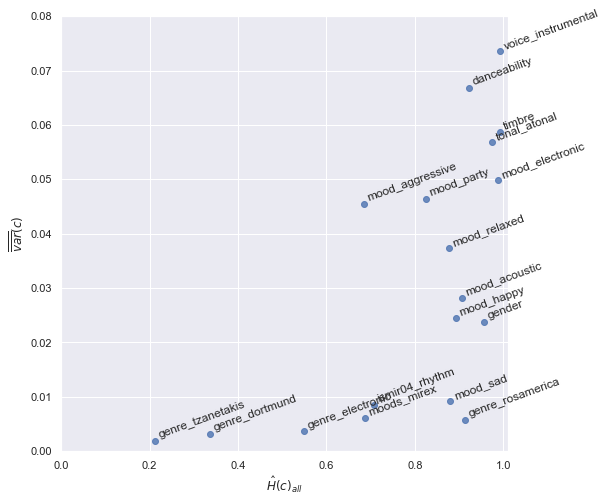

In [14]:
toplot = pd.DataFrame(columns=['Mean normalized entropy', 'Pooled variance'])
toplot['Mean normalized entropy'] = norm_entropy
toplot['Pooled variance'] = avg_variance

display(toplot)
# plot = toplot.plot(kind='scatter', x='Pooled variance', y='Normalized entropy')

plt.figure(figsize=(8,8))
p1 = sns.regplot('Mean normalized entropy', 'Pooled variance', toplot, fit_reg=False)
for index, val in toplot.iterrows():
    p1.text(val['Mean normalized entropy'] + 0.005, val['Pooled variance'] + 0.0005, index, horizontalalignment='left', rotation=20)
p1.set_xlabel('$\hat{H}(c)_{all}$')
p1.set_ylabel('$\overline{\overline{var}}(c)$')
p1.set_ylim([0,0.08])
p1.set_xlim([0,1.01])

In [15]:
print(toplot.sort_values(by='Mean normalized entropy').to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Mean normalized entropy &  Pooled variance \\
\midrule
genre\_tzanetakis   &                 0.210992 &         0.001957 \\
genre\_dortmund     &                 0.337265 &         0.003255 \\
genre\_electronic   &                 0.550274 &         0.003670 \\
mood\_aggressive    &                 0.684244 &         0.045529 \\
moods\_mirex        &                 0.686701 &         0.006166 \\
ismir04\_rhythm     &                 0.707772 &         0.008489 \\
mood\_party         &                 0.825267 &         0.046484 \\
mood\_relaxed       &                 0.877459 &         0.037327 \\
mood\_sad           &                 0.880068 &         0.009161 \\
mood\_happy         &                 0.892659 &         0.024462 \\
mood\_acoustic      &                 0.905857 &         0.028181 \\
genre\_rosamerica   &                 0.914024 &         0.005816 \\
danceability       &                 0.922382 &         0.066811 \\
gender       

From this, we can identify the following four quadrants:
<img src='img/plot_h1.png' />

Which gives us the hypothesis:
$G_{1} = \{moods\_mirex, ismir04\_rhythm, mood\_sad, genre\_rosamerica, gender, mood\_happy, mood\_acoustic, mood\_relaxed\}$
$G_{2} = \{mood\_aggressive, mood\_party, mood\_electronic, tonal\_atonal, timbre, danceability, voice\_instrumental\}$

$H_{1} = $ $G_{1}$ is more 'stable' in it's results than $G_{2}$
$H_{0} = $ there is no significant difference in 'stability' between $G_{1}$ and $G_{2}$

# Visual representation of stability and hypothesis testing
Another way to look at the stability is to construct some embedding space based on the features of the songs. Intuitively, if ouputs of the classifiers for a song are similar, and thus their features are relatively similar, then they should be mapped to roughly the same spot in the embedding space and then their distance should also be small. If they are far apart, then they are relatively dissimilar.

We first plot the embedding from PCA with two principal components ran over all classifiers to give a general overview of the mapping. Highlighted points in the embedding are recordings for the same song:

In [16]:
from sklearn.decomposition import PCA

# Load in dataset unfiltered, because we also want to use recordings with just one submission to build the embedding
#ab = acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainz.h5')

ids_most = acousticbrainz.groupby(level=0).size().sort_values(ascending=False)[:7].index.values

embedded = PCA(n_components=2).fit_transform(acousticbrainz)
df = pd.DataFrame(embedded, columns=['x', 'y'])
df['id'] = acousticbrainz.index.get_level_values(level=0)

filtered = df[df['id'].isin(ids_most)]

plot = sns.scatterplot(data=df, x='x', y='y', alpha=0.02)
sns.scatterplot(data=filtered, x='x', y='y', hue='id', style='id', ax=plot)
plt.title("Embedding for all classifiers")
plt.show()

ModuleNotFoundError: No module named 'sklearn'

We can see that generally speaking the recordings are clustered in this embedding space, however the clusters are not very tight. We are interested in using this technique to test $H_1$, thus we create two embeddings, one for $G_1$ and one for $G_2$:

In [ ]:
# Calculate embedding for group 1
g1 = PCA(n_components=2).fit_transform(acousticbrainz[['moods_mirex', 'ismir04_rhythm', 'mood_sad', 'genre_rosamerica', 
                                                       'gender', 'mood_happy', 'mood_acoustic', 'mood_relaxed']])
df1 = pd.DataFrame(g1, columns=['x', 'y'])
df1['id'] = acousticbrainz.index.get_level_values(level=0)
f1 = df1[df1['id'].isin(ids_most)]

# Calculate embedding for group 2
g2 = PCA(n_components=2).fit_transform(acousticbrainz[['mood_aggressive', 'mood_party', 'mood_electronic', 'tonal_atonal',
                                                      'timbre', 'danceability', 'voice_instrumental']])
df2 = pd.DataFrame(g2, columns=['x', 'y'])
df2['id'] = acousticbrainz.index.get_level_values(level=0)
f2 = df2[df2['id'].isin(ids_most)]

# Plot both embeddings visually
p1 = sns.scatterplot(data=df1, x='x', y='y', alpha=0.02)
sns.scatterplot(data=f1, x='x', y='y', hue='id', style='id', ax=p1)
plt.title('Embedding for G1')
plt.show()

p2 = sns.scatterplot(data=df2, x='x', y='y', alpha=0.02)
sns.scatterplot(data=f2, x='x', y='y', hue='id', style='id', ax=p2)
plt.title('Embedding for G2')
plt.show()

Visually, it is very difficult to say which of these embeddings is more stable, for each embedding we can calculate the euclidean pairwise distances between all the related recordings. If the embedding is more stable, the mean pairwise distance should be lower. Thus, we would expect that: $$mean(pdist(G1)) < mean(pdist(G2))$$

We can then use the two tailed t-test statistic to check if the means differ significantly:

In [ ]:
from scipy.spatial.distance import pdist
from scipy.stats import ttest_ind

# Calculate pdist for G1
d1 = np.concatenate(df1.groupby('id').apply(pdist).values)

# Calculate pdist for G2
d2 = np.concatenate(df2.groupby('id').apply(pdist).values)

print(f"G1: M={np.mean(d1)}, SD={np.std(d1)}")
print(f"G2: M={np.mean(d2)}, SD={np.std(d2)}")

t = ttest_ind(d2, d1)
print(f"t({len(d1) + len(d2) - 2})={t.statistic}), p={t.pvalue}")

The effect size can be calculated using the [formula for cohens d](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/):
$$d=\frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{(n_1-1)SD^2_1+(n_2-1)SD_2^2}{n_1+n_2-2}}}$$

In [ ]:
def cohens_d(a, b):
    nom = np.mean(a) - np.mean(b)
    denom = math.sqrt(
        ((len(a)-1) * np.std(a)**2 + (len(b)-1) * np.std(b)**2) /
        (len(a) + len(b) - 2)
    )
    
    return nom/denom

cohens_d(d2, d1)

Thus, we can reject $H_0$ and the data from the embeddings suggests there is a medium effect on the mean difference between the two groups of classifiers in the embedding space

# Variance over labels instead of over probabilities
It can be argued that variance in the probability distribution over the labels is not harmful, as long as the labels themselves remain stable. It is more harmful when a classifier 'flips' the label. To calculate this variance, we take the same approach as with the probabilities by pooling the different populations, however now we look at the discrete labels.

For this we can, again use the normalized entropy:
$$S=-\sum_{i}\frac{p_i \log_2 p_i}{log_2 n}$$
However, now in the best case the entropy for a population is 0 (the label does not flip), and higher entropy means more flips and thus less reliability


We first calculate the label probabilities per recording:


In [17]:
grouped_filt = acousticbrainz_filt.groupby(axis=1, level=0).idxmax(axis=1).applymap(lambda x: x[1])
population_probabilities = grouped_filt.stack().groupby(level=[0,2]).value_counts(normalize=True).unstack().fillna(value=0)
population_probabilities

ChaChaCha  Cluster1  \
000009a8-34f1-4c58-a8de-1d99809cd626 danceability              0.0       0.0   
                                     gender                    0.0       0.0   
                                     genre_dortmund            0.0       0.0   
                                     genre_electronic          0.0       0.0   
                                     genre_rosamerica          0.0       0.0   
...                                                            ...       ...   
ffffefa3-45ae-4f72-9177-523b316a6534 mood_sad                  0.0       0.0   
                                     moods_mirex               0.0       0.0   
                                     timbre                    0.0       0.0   
                                     tonal_atonal              0.0       0.0   
                                     voice_instrumental        0.0       0.0   

                                                         Cluster2  Cluster3  \
000009a8-34f1-4c58-a8de-1d99809cd626 danceability             0.0       0.0   
                                     gender                   0.0       0.0   
                                     genre_dortmund           0.0       0.0   
                                     genre_electronic         0.0       0.0   
                                     genre_rosamerica         0.0       0.0   
...                                                           ...       ...   
ffffefa3-45ae-4f72-9177-523b316a6534 mood_sad                 0.0       0.0   
                                     moods_mirex              0.0       0.0   
                                     timbre                   0.0       0.0   
                                     tonal_atonal             0.0       0.0   
                                     voice_instrumental       0.0       0.0   

                                                         Cluster4  Cluster5  \
000009a8-34f1-4c58-a8de-1d99809cd626 danceability             0.0       0.0   
                                     gender                   0.0       0.0   
                                     genre_dortmund           0.0       0.0   
                                     genre_electronic         0.0       0.0   
                                     genre_rosamerica         0.0       0.0   
...                                                           ...       ...   
ffffefa3-45ae-4f72-9177-523b316a6534 mood_sad                 0.0       0.0   
                                     moods_mirex              0.0       1.0   
                                     timbre                   0.0       0.0   
                                     tonal_atonal             0.0       0.0   
                                     voice_instrumental       0.0       0.0   

                                                         Jive  Quickstep  \
000009a8-34f1-4c58-a8de-1d99809cd626 danceability         0.0        0.0   
                                     gender               0.0        0.0   
                                     genre_dortmund       0.0        0.0   
                                     genre_electronic     0.0        0.0   
                                     genre_rosamerica     0.0        0.0   
...                                                       ...        ...   
ffffefa3-45ae-4f72-9177-523b316a6534 mood_sad             0.0        0.0   
                                     moods_mirex          0.0        0.0   
                                     timbre               0.0        0.0   
                                     tonal_atonal         0.0        0.0   
                                     voice_instrumental   0.0        0.0   

                                                         Rumba-American  \
000009a8-34f1-4c58-a8de-1d99809cd626 danceability                   0.0   
                                     gender                         0.0   
                                     genre_dortmund         

Now we pool the entropy much in the way we pooled the variances by taking the weighted average:
$$S_w=\frac{\sum_{i=0}^{k-1}n_i S_n}{\sum_{i=0}^{k-1}n_i}$$

In [18]:
pop_entropies = population_probabilities.progress_apply(lambda row: entropy(row, base=normalizers[row.name[1]]), axis=1)

In [19]:
samplesizes = acousticbrainz_filt.groupby(level=0).size()

In [20]:
pooled_entropy = (pop_entropies.unstack().mul(samplesizes, axis=0)).sum() / samplesizes.sum()
pooled_entropy.sort_values()

genre_tzanetakis      0.030846
genre_dortmund        0.034370
genre_electronic      0.074624
genre_rosamerica      0.110834
moods_mirex           0.121858
mood_sad              0.125632
ismir04_rhythm        0.140486
mood_acoustic         0.152564
mood_aggressive       0.185294
mood_happy            0.234724
mood_party            0.250273
tonal_atonal          0.274210
timbre                0.274619
mood_relaxed          0.275083
mood_electronic       0.275585
danceability          0.278202
gender                0.285081
voice_instrumental    0.316232
dtype: float64

For these values it holds, the higher the pooled entropy, the more the discrete label flips. Thus, lower values are more stable.

### 95% confidence intervals:

In [21]:
a = pop_entropies.unstack().loc[pop_entropies.unstack().index.repeat(samplesizes)]
se = a.var() / math.sqrt(samplesizes.sum())
ci_95 = se * scipy.stats.t.ppf(0.975, samplesizes.sum())
ci_95.sort_values()

genre_tzanetakis      0.000016
genre_dortmund        0.000020
genre_electronic      0.000048
ismir04_rhythm        0.000050
genre_rosamerica      0.000050
moods_mirex           0.000077
mood_sad              0.000190
mood_acoustic         0.000225
mood_aggressive       0.000260
mood_happy            0.000303
mood_party            0.000322
timbre                0.000337
tonal_atonal          0.000339
mood_electronic       0.000340
danceability          0.000341
mood_relaxed          0.000341
gender                0.000348
voice_instrumental    0.000361
dtype: float64

,Normalized entropy,Label stability (Pooled normalized entropy)
danceability,0.922382,0.278202
gender,0.956663,0.285081
genre_dortmund,0.337265,0.034370
genre_electronic,0.550274,0.074624
genre_rosamerica,0.914024,0.110834
genre_tzanetakis,0.210992,0.030846
ismir04_rhythm,0.707772,0.140486
mood_acoustic,0.905857,0.152564
mood_aggressive,0.684244,0.185294
mood_electronic,0.987134,0.275585


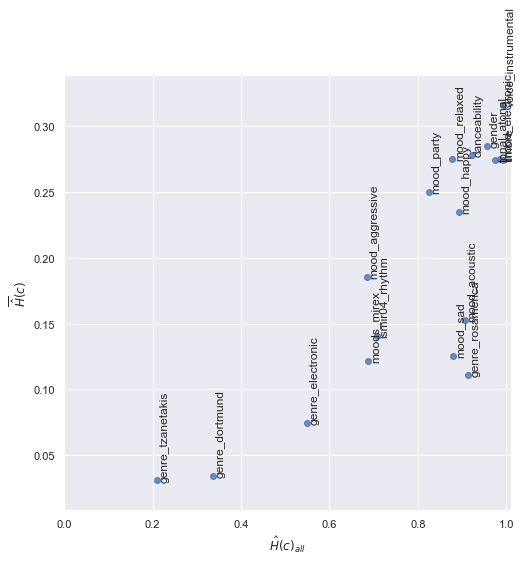

In [26]:
toplot = pd.DataFrame(columns=['Normalized entropy', 'Label stability (Pooled normalized entropy)'])
toplot['Normalized entropy'] = norm_entropy
toplot['Label stability (Pooled normalized entropy)'] = pooled_entropy

display(toplot)

plt.figure(figsize=(8,8))
p2 = sns.regplot('Normalized entropy', 'Label stability (Pooled normalized entropy)', toplot, fit_reg=False)
for index, val in toplot.iterrows():
    p2.text(val['Normalized entropy'] + 0.005, val['Label stability (Pooled normalized entropy)'] + 0.0005, index, horizontalalignment='left', rotation=90)

p2.set_xlabel('$\hat{H}(c)_{all}$')
p2.set_ylabel('$\overline{\hat{H}}(c)$')
p2.set_xlim([0,1.01])

plt.show()

In [23]:
print(toplot.sort_values('Normalized entropy').to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Normalized entropy &  Label stability (Pooled normalized entropy) \\
\midrule
genre\_tzanetakis   &            0.210992 &                                     0.030846 \\
genre\_dortmund     &            0.337265 &                                     0.034370 \\
genre\_electronic   &            0.550274 &                                     0.074624 \\
mood\_aggressive    &            0.684244 &                                     0.185294 \\
moods\_mirex        &            0.686701 &                                     0.121858 \\
ismir04\_rhythm     &            0.707772 &                                     0.140486 \\
mood\_party         &            0.825267 &                                     0.250273 \\
mood\_relaxed       &            0.877459 &                                     0.275083 \\
mood\_sad           &            0.880068 &                                     0.125632 \\
mood\_happy         &            0.892659 &               

## Main differences between the results in mean pooled variance and pooled entropy

In [24]:
print('Mean pooled variance:')
display(avg_variance.sort_values(ascending=True))
print('pooled entropy:')
display(pooled_entropy.sort_values(ascending=True))


Mean pooled variance:


genre_tzanetakis      0.001957
genre_dortmund        0.003255
genre_electronic      0.003670
genre_rosamerica      0.005816
moods_mirex           0.006166
ismir04_rhythm        0.008489
mood_sad              0.009161
gender                0.023747
mood_happy            0.024462
mood_acoustic         0.028181
mood_relaxed          0.037327
mood_aggressive       0.045529
mood_party            0.046484
mood_electronic       0.049802
tonal_atonal          0.056830
timbre                0.058701
danceability          0.066811
voice_instrumental    0.073534
dtype: float64

pooled entropy:


genre_tzanetakis      0.030846
genre_dortmund        0.034370
genre_electronic      0.074624
genre_rosamerica      0.110834
moods_mirex           0.121858
mood_sad              0.125632
ismir04_rhythm        0.140486
mood_acoustic         0.152564
mood_aggressive       0.185294
mood_happy            0.234724
mood_party            0.250273
tonal_atonal          0.274210
timbre                0.274619
mood_relaxed          0.275083
mood_electronic       0.275585
danceability          0.278202
gender                0.285081
voice_instrumental    0.316232
dtype: float64

# Implaction of these estimates through simulating data (WIP)

In [28]:
from scipy import stats
import random

def estimate_probs(ent, no_labels):
    probs = np.full(no_labels, 1/no_labels)
    epsilon = ent - stats.entropy(probs, base=no_labels)    
    step = (1 - probs[0]) / 2    
    
    # Approximation not good enough
    while(abs(epsilon) > np.finfo(float).eps):
        # Still need to increase
        if epsilon < 0:
            probs[0] += step
            for i in range(1, len(probs)):
                probs[i] -= step/(len(probs)-1)
        # Overshot
        else:
            probs[0] -= step
            for i in range(1, len(probs)):
                probs[i] += step/(len(probs)-1)
                
        epsilon = ent - stats.entropy(probs, base=no_labels)
        step = step/2
    
    return probs
         
            

def simulate(norm_ent, pooled_ent, no_labels, no_songs, max_submissions):
    # Generate possible labels
    labels = list(range(0, no_labels))
    
    # Generate ground truth
    truth = []
    for i in range(0, no_songs):
        truth.append(random.choice(labels))
        
    # Generate random amount of submissions
    submissions = []
    for i in range(0, no_songs):
        submissions.append(random.choice(range(1, max_submissions)))
        
    # Assumptions:
    # - The classifier is accurate and gives back the ground truth, with only the bias and the label variance influencing the
    #   accuracy
    # - If normalized entropy is 1.0, then the classifier is totally unbiased (equally likely to give all possible results)
    # - Acousticbrainz data is equally distributed over the labels
    # - If normalized entropy is some other value, we approximate the underlying probabilities using estimate_probs
    # - Probability of making a mistake due to bias is [1/nlabels - estimate_probs(norm_ent)[0]]
    # - Probability of the label flipping to another label is estimate_probs(pooled_ent)
    
    # Probabilies of the classifier bias, approximated from the normalized entropy for the classifier
    probs_bias = estimate_probs(norm_ent, no_labels)
    probs_bias = abs(1/no_labels - probs_bias[0])
    temp = np.full(no_labels, probs_bias/(no_labels-1))
    temp[0] = 1-probs_bias
    probs_bias = temp
    
    # Probability of the label flipping, approximated from the pooled entropy for the classifier
    probs_flip = estimate_probs(pooled_ent, no_labels)
    
    print(f"Bias probabilities: {probs_bias}")
    print(f"Flip probabilities: {probs_flip}")
    
    # Simulate predictions
    predictions = []
    for i in tqdm(range(0, no_songs)):
        song_pred = []
        
        lab = [truth[i]] + [x for x in labels if x != truth[i]]
        
        pred_bias = np.random.choice(lab, size= submissions[i], p=probs_bias)
        
        for item in pred_bias:
            lab = [item] + [x for x  in labels if x != item]
            pred_bias_flip = np.random.choice(lab, size=1, p=probs_flip)[0]
            song_pred.append(pred_bias_flip)
        
        predictions.append(song_pred)
    
    res = []
    for i in range(0, no_songs):
        for j in range(0, len(predictions[i])):
            res.append([i, truth[i], predictions[i][j]])
    
    return pd.DataFrame(res, columns=['songID', 'truth', 'prediction'])
        
def simulate_classifier(name, no_songs, max_submissions):
    print(f"Simulating data for classifier {name} with {no_songs} songs with a maximum of {max_submissions} submissions per song...")
    print(f"Normalized entropy: {norm_entropy[name]}")
    print(f"Pooled entropy: {pooled_entropy[name]}")
    data = simulate(norm_entropy[name], pooled_entropy[name], len(acousticbrainz[name].columns), no_songs, max_submissions)
    predictions = len(data)
    correct = len(data[data['truth'] == data['prediction']])
    accuracy = correct/predictions
    print(f"{correct}/{predictions}: {accuracy*100}%\n\n\n")
    return [name, predictions, correct, accuracy]
    

scores = []
for classifier in acousticbrainz.columns.get_level_values(0).drop_duplicates():
    scores.append(simulate_classifier(classifier, 1000, 100))

scores = pd.DataFrame(scores, columns=['name', 'predictions', 'correct', 'accuracy'])
scores.sort_values(by='accuracy')

        

Simulating data for classifier danceability with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.9223823907921024
Pooled entropy: 0.2782021770429641
Bias probabilities: [0.83747547 0.16252453]
Flip probabilities: [0.95191584 0.04808416]



40505/50320: 80.49483306836248%



Simulating data for classifier gender with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.9566634751796921
Pooled entropy: 0.28508142599569986
Bias probabilities: [0.87806438 0.12193562]
Flip probabilities: [0.95030934 0.04969066]



41529/49487: 83.91900903267525%



Simulating data for classifier genre_dortmund with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.33726470242740186
Pooled entropy: 0.034370163469353045
Bias probabilities: [0.26279754 0.09215031 0.09215031 0.09215031 0.09215031 0.09215031
 0.09215031 0.09215031 0.09215031]
Flip probabilities: [0.99019104 0.00122612 0.00122612 0.00122612 0.00122612 0.00122612
 0.00122612 0.00122612 0.00122612]



13555/52078: 26.028265294366143%



Simulating data for classifier genre_electronic with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.5502739382763253
Pooled entropy: 0.07462427806569566
Bias probabilities: [0.44072573 0.13981857 0.13981857 0.13981857 0.13981857]
Flip probabilities: [0.9810671  0.00473322 0.00473322 0.00473322 0.00473322]



21226/48939: 43.37236151126913%



Simulating data for classifier genre_rosamerica with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.9140237956004958
Pooled entropy: 0.11083441906303643
Bias probabilities: [0.76635885 0.03337731 0.03337731 0.03337731 0.03337731 0.03337731
 0.03337731 0.03337731]
Flip probabilities: [0.96296443 0.0052908  0.0052908  0.0052908  0.0052908  0.0052908
 0.0052908  0.0052908 ]



36927/49724: 74.26393693186388%



Simulating data for classifier genre_tzanetakis with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.2109921263944129
Pooled entropy: 0.030845778787540357
Bias probabilities: [0.18680818 0.09035465 0.09035465 0.09035465 0.09035465 0.09035465
 0.09035465 0.09035465 0.09035465 0.09035465]
Flip probabilities: [0.99101509 0.00099832 0.00099832 0.00099832 0.00099832 0.00099832
 0.00099832 0.00099832 0.00099832 0.00099832]



8920/47985: 18.58914244034594%



Simulating data for classifier ismir04_rhythm with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.7077722902335535
Pooled entropy: 0.14048642686322368
Bias probabilities: [0.53063946 0.05215117 0.05215117 0.05215117 0.05215117 0.05215117
 0.05215117 0.05215117 0.05215117 0.05215117]
Flip probabilities: [0.94704458 0.00588394 0.00588394 0.00588394 0.00588394 0.00588394
 0.00588394 0.00588394 0.00588394 0.00588394]



26562/52385: 50.70535458623652%



Simulating data for classifier mood_acoustic with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.9058567404963085
Pooled entropy: 0.15256358562028488
Bias probabilities: [0.82136228 0.17863772]
Flip probabilities: [0.97799338 0.02200662]



42002/52026: 80.73271056779303%



Simulating data for classifier mood_aggressive with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.6842442969435744
Pooled entropy: 0.1852935052632298
Bias probabilities: [0.68191307 0.31808693]
Flip probabilities: [0.97179795 0.02820205]



33624/49996: 67.25338027042163%



Simulating data for classifier mood_electronic with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.9871343737765857
Pooled entropy: 0.27558486315480907
Bias probabilities: [0.93332455 0.06667545]
Flip probabilities: [0.95252215 0.04747785]



46039/51727: 89.00380845593212%



Simulating data for classifier mood_happy with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.8926590572264446
Pooled entropy: 0.23472412872173568
Bias probabilities: [0.80955495 0.19044505]
Flip probabilities: [0.96163947 0.03836053]



38685/49003: 78.94414627675856%



Simulating data for classifier mood_party with 1000 songs with a maximum of 100 submissions per song...
Normalized entropy: 0.8252670201706122
Pooled entropy: 0.2502730096764949
Bias probabilities: [0.75902203 0.24097797]
Flip probabilities: [0.95824693 0.04175307]


KeyboardInterrupt: 

# Classifier correlations
Another way to look at if the classifiers present in acousticbrainz do report what they intent to report in a *consistent* way is to check correlations between the different classifiers.

The reasoning behind this is as follows: we know some correlations from experience and/or psychology, for example if a piece of music is happy, then it is probably not sad (and thus we would expect a negative correlation between `mood_happy` and `mood_sad`) or we would expect that `mood_party` and `dancability` are slightly correlated, since some, but not all parties involve dancing.

If classifiers do not show the correlations we expect, then either:
- The hypothesis of the correlation is wrong
- The classifier does not (or does not fully) model the expected feature in the music correctly

Thus, if we make a list of likely correlation hypotheses, then we can use the correlation between the classifiers as another metric for the reliability of the classifiers.

### Correlation hypotheses
#### Genre classification
- `genre_dortmund, blues` - `genre_tzanetakis, blu`: strong positive correlation
- `genre_dortmund, electronic` - `genre_tzanetakis, hip`: moderate positive correlation
- `genre_dortmund, folkcountry` - `genre_tzanetakis, cou`: positive correlation
- `genre_dortmund, jazz` - `genre_tzanetakis, jaz`: strong positive correlation
- `genre_dortmund, pop` - `genre_tzanetakis, pop`: strong positive correlation
- `genre_dortmund, raphiphop` - `genre_tzanetakis, hip`: positive correlation
- `genre_dortmund, rock` - `genre_tzanetakis, roc`: strong positive correlation
- `genre_dortmund, blues` - `genre_rosamerica, rhy`: positive correlation
- `genre_dortmund, electronic` - `genre_rosamerica, dan`: moderate positive correlation
- `genre_dortmund, jazz` - `genre_rosamerica, jaz`: strong positive correlation
- `genre_dortmund, pop` - `genre_rosamerica, pop`: strong positive correlation
- `genre_dortmund, raphiphop` - `genre_rosamerica, hip`: positive correlation
- `genre_dortmund, rock` - `genre_rosamerica, roc`: strong positive correlation
- `genre_rosamerica, cla` - `genre_tzanetakis, cla`: strong positive correlation
- `genre_rosamerica, hip` - `genre_tzanetakis, hip`: strong positive correlation
- `genre_rosamerica, jaz` - `genre_tzanetakis, jaz`: strong positive correlation
- `genre_rosamerica, pop` - `genre_tzanetakis, pop`: strong positive correlation
- `genre_rosamerica, rhy` - `genre_tzanetakis, blu`: positive correlation
- `genre_rosamerica, roc` - `genre_tzanetakis, roc`: strong positive correlation
#### Mirex clusters
- `moods_mirex, Cluster2` - `mood_happy, happy` : positive correlation
- `moods_mirex, Cluster2` - `mood_sad, not_sad` : positive correlation
- `moods_mirex, Cluster3` - `mood_happy, not_happy` : positive correlation
- `moods_mirex, Cluster3` - `mood_sad, sad` : positive correlation
- `moods_mirex, Cluster5` - `mood_aggressive, aggressive` : positive correlation
- `moods_mirex, Cluster5` - `mood_relaxed, not_relaxed`: positive correlation

#### Other correlations
- `danceability, danceable` - `mood_party, party`: positive correlation
- `danceability, danceable` - `mood_relaxed, not_relaxed`: moderate positive correlation
- `danceability, danceable` - `genre_rosamerica, dan`: positive correlation
- `danceability, danceable` - `genre_tzanetakis, dis`: positive correlation
- `mood_acoustic, acoustic` - `mood_electronic, not_electronic`: positive correlation
- `mood_aggressive, aggressive` - `mood_relaxed, not_relaxed`: positive correlation
- `mood_electronic, electronic` - `genre_dortmund, electronic`: strong positive correlation
- `mood_happy, happy` - `mood_sad, not_sad`: positive correlation
- `mood_happy, happy` - `mood_party, party`: positive correlation


Now, let's calculate these correlations from the sample data and see if they match the hypotheses:

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainz.h5')

In [ ]:
from collections import defaultdict
from scipy import stats

from IPython.display import Markdown

genre_corr_tuples = [("genre_dortmund, blues", "genre_tzanetakis, blu"),
("genre_dortmund, electronic", "genre_tzanetakis, hip"),
("genre_dortmund, folkcountry", "genre_tzanetakis, cou"),
("genre_dortmund, jazz", "genre_tzanetakis, jaz"),
("genre_dortmund, pop", "genre_tzanetakis, pop"),
("genre_dortmund, raphiphop", "genre_tzanetakis, hip"),
("genre_dortmund, rock", "genre_tzanetakis, roc"),
("genre_dortmund, blues", "genre_rosamerica, rhy"),
("genre_dortmund, electronic", "genre_rosamerica, dan"),
("genre_dortmund, jazz", "genre_rosamerica, jaz"),
("genre_dortmund, pop", "genre_rosamerica, pop"),
("genre_dortmund, raphiphop", "genre_rosamerica, hip"),
("genre_dortmund, rock", "genre_rosamerica, roc"),
("genre_rosamerica, cla", "genre_tzanetakis, cla"),
("genre_rosamerica, hip", "genre_tzanetakis, hip"),
("genre_rosamerica, jaz", "genre_tzanetakis, jaz"),
("genre_rosamerica, pop", "genre_tzanetakis, pop"),
("genre_rosamerica, rhy", "genre_tzanetakis, blu"),
("genre_rosamerica, roc", "genre_tzanetakis, roc")]

mirex_corr_tuples = [("moods_mirex, Cluster2", "mood_happy, happy"),
("moods_mirex, Cluster2", "mood_sad, not_sad"),
("moods_mirex, Cluster3", "mood_happy, not_happy"),
("moods_mirex, Cluster3", "mood_sad, sad"),
("moods_mirex, Cluster5", "mood_aggressive, aggressive"),
("moods_mirex, Cluster5", "mood_relaxed, not_relaxed")]

other_corr_tuples = [("danceability, danceable", "mood_party, party"),
("danceability, danceable", "mood_relaxed, not_relaxed"),
("danceability, danceable", "genre_rosamerica, dan"),
("danceability, danceable", "genre_tzanetakis, dis"),
("mood_acoustic, acoustic", "mood_electronic, not_electronic"),
("mood_aggressive, aggressive", "mood_relaxed, not_relaxed"),
("mood_electronic, electronic", "genre_dortmund, electronic"),
("mood_happy, happy", "mood_sad, not_sad"),
("mood_happy, happy", "mood_party, party")]

# Using cohens benchmark for correlation strength: http://www.psychology.emory.edu/clinical/bliwise/Tutorials/SCATTER/scatterplots/effect.htm
genre_corr_tuples_hyp = [.5,
                        .3,
                        .3,
                        .5,
                        .5,
                        .3,
                        .5,
                        .3,
                        .3,
                        .5,
                        .5,
                        .3,
                        .5,
                        .5,
                        .5,
                        .5,
                        .5,
                        .3,
                        .5]

mirex_corr_tuples_hyp = [.3,
                        .3,
                        .3,
                        .3,
                        .3,
                        .3]

other_corr_tuples_hyp = [.3,
                        .3,
                        .3,
                        .3,
                        .3,
                        .3,
                        .5,
                        .3,
                        .3]

# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# For every pair, check if the correlation hypthesis is true
def check_hypotheses(tocheck, hyp):
    assert(len(tocheck) == len(hyp))
    
    res = dict()
    
    for i in range(0, len(tocheck)):
        a=tocheck[i][0]
        b=tocheck[i][1]
        a_spl = tocheck[i][0].split(', ')
        x = acousticbrainz[a_spl[0]][a_spl[1]]
        b_spl = tocheck[i][1].split(', ')
        y = acousticbrainz[b_spl[0]][b_spl[1]]
        pearson_r = pearsonr_ci(x,y)

        for item in [a,b]:
            # Create fields
            if item not in res.keys():
                res[item] = {'total': 0, 'correct': 0}
            
            # Count
            if pearson_r[3] >= hyp[i]:
                res[item]['correct'] += 1
            res[item]['total'] += 1
    
    return pd.DataFrame(res)

            
            
                
tocheck = np.concatenate((genre_corr_tuples, mirex_corr_tuples, other_corr_tuples))
hyp = np.concatenate((genre_corr_tuples_hyp, mirex_corr_tuples_hyp, other_corr_tuples_hyp))

counts = check_hypotheses(tocheck, hyp).transpose()
counts['ratio'] = counts['correct'] / counts['total']
counts.sort_values(by='ratio', ascending=False)
    
    
    

In [ ]:
# Print the correlations
def print_correlations(tocheck):
    for t in tocheck:
        print("{a}\n{b}".format(a=t[0], b=t[1]))
        a_spl = t[0].split(', ')
        a = acousticbrainz[a_spl[0]][a_spl[1]]
        b_spl = t[1].split(', ')
        b = acousticbrainz[b_spl[0]][b_spl[1]]
        pearson_r = pearsonr(a,b)
        kendall_tau = kendalltau(a,b)
        print("pearson r: {r}, p: {p}".format(r=pearson_r[0], p=pearson_r[1]))
        print("kendall tau: {r}, p: {p}\n".format(r=kendall_tau[0], p=kendall_tau[1]))
        
        toplot = pd.DataFrame().append(a.rename(t[0])).append(b.rename(t[1])).transpose()
        sns.set(font_scale=3)
        plt.figure(figsize=(24,24))
        sns.regplot(t[0], t[1], toplot, fit_reg=False, scatter_kws={'s':1, 'marker': ','})
        plt.xlim(-0.01,1)
        plt.ylim(-0.01,1)
        plt.show()
        plt.close()

display(Markdown("#### Genre classification"))
print_correlations(genre_corr_tuples)

display(Markdown("#### Mirex clusters"))
print_correlations(mirex_corr_tuples)

display(Markdown("#### Other correlations"))
print_correlations(other_corr_tuples)